In [1]:
%load_ext autoreload
%autoreload 2

# Set Up and Data Loading

This kernel uses fastai and Huggingface transformser. fastai is already installed on Kaggle, and [here](https://www.kaggle.com/c/tensorflow2-question-answering/discussion/117716) is a discussion post that shows how to get Huggingface installled.

This statement prints all of the directories in the /kaggle/input/ directory. This can be useful when trying to determine the path of the external datasets.

In [2]:
from gquest_nbdev.fastai_huggingface import * 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
from pathlib import Path 
from fastai.text import *
from fastai.tabular import *

In [3]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

A utility function to set the seed for generating random numbers

In [4]:
seed=42
seed_all(seed)

In [5]:
#os.chdir(Path("./gquest_nbdev"))
#os.chdir(Path("/home/mrdbarros/projetos/gquest_nbdev"))

In [6]:
model_type = 'roberta'
pretrained_model_name = 'roberta-base' # 'roberta-base-openai-detector'
DATA_ROOT = Path("../input/google-quest-challenge/")
MODEL_ROOT = Path("../input/"+pretrained_model_name)
train = pd.read_csv(DATA_ROOT / 'train.csv')
test = pd.read_csv(DATA_ROOT / 'test.csv')
sample_sub = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
print(train.shape,test.shape)
download_model=True

(6079, 41) (476, 11)


The training data. In this kernel, I'll use the `question_title`, `question_body` and `answer` columns.

In [7]:
train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


The predicted lables are in the columns of the sample submission. Note that some labels are with respect to the question, and some are with respect to the answer.

In [8]:
labels = list(sample_sub.columns[1:].values)

In [9]:
for label in labels: print(label) 

question_asker_intent_understanding
question_body_critical
question_conversational
question_expect_short_answer
question_fact_seeking
question_has_commonly_accepted_answer
question_interestingness_others
question_interestingness_self
question_multi_intent
question_not_really_a_question
question_opinion_seeking
question_type_choice
question_type_compare
question_type_consequence
question_type_definition
question_type_entity
question_type_instructions
question_type_procedure
question_type_reason_explanation
question_type_spelling
question_well_written
answer_helpful
answer_level_of_information
answer_plausible
answer_relevance
answer_satisfaction
answer_type_instructions
answer_type_procedure
answer_type_reason_explanation
answer_well_written


# Fine Tuning

In [10]:
train[['question_title','question_body','answer']].to_csv(Path('../input/raw_text.csv'))

In [11]:
# Parameters
seed = 42
use_fp16 = True
bs = 8
MAX_SEQUENCE_LENGTH = 512
#train=train[:300]

In [12]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [13]:
if download_model:
    new_dir=Path("../input")/pretrained_model_name
    !mkdir {new_dir}
    transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
    transformer_tokenizer.save_pretrained(MODEL_ROOT)

mkdir: cannot create directory ‘../input/roberta-base’: File exists


In [14]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [15]:
train['question_title_body']=train['question_title'] +" " + train['question_body']
test['question_title_body']=test['question_title'] +" " + test['question_body']

In [16]:
if download_model:
    transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
    transformer_tokenizer.save_pretrained(MODEL_ROOT)

In [17]:
transformer_tokenizer = tokenizer_class.from_pretrained(MODEL_ROOT)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer_MultiColumn(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[]#,n_cpus=1
                                         )

In [18]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessorDualBert(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [19]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [20]:
unique_sorted_values=[np.sort(train[labels[i]].unique()) for i in range(len(labels))]
unique_sorted_values


[array([0.333333, 0.444444, 0.5     , 0.555556, 0.666667, 0.777778, 0.833333, 0.888889, 1.      ]),
 array([0.333333, 0.444444, 0.5     , 0.555556, 0.666667, 0.777778, 0.833333, 0.888889, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.333333, 0.444444, 0.5     , 0.555556, 0.666667, 0.777778, 0.833333, 0.888889, 1.      ]),
 array([0.333333, 0.444444, 0.5     , 0.555556, 0.666667, 0.777778, 0.833333, 0.888889, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),
 array([0.      , 0.333333, 0.5     , 0.666667, 1.      ]),


In [21]:
labels

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [22]:
from gquest_nbdev.fastai_huggingface import * 

In [23]:
train['host']=train['host'].astype('category')
train['category']=train['category'].astype('category')

In [24]:
mixed_list= MixedObjectList.from_df([train,train], cols_list=[['question_title_body','answer'],['category','host']], 
                 processors=[transformer_processor,transformer_processor],item_type_list=[TextList_Multi,TabularList])

In [25]:
type(mixed_list)

gquest_nbdev.fastai_huggingface.MixedObjectList

In [26]:
sd_multi = (mixed_list.split_subsets(train_size=0.8,valid_size=0.2))
                #.split_by_rand_pct(0.1,seed=seed)
                 

In [27]:
type(sd_multi)

gquest_nbdev.fastai_huggingface.MixedObjectLists

In [28]:
sd_label_multi = (sd_multi.label_from_df(cols=labels
                                         #,label_cls=MultiCategoryList
                                         )
                  )

In [29]:
type(sd_label_multi)

gquest_nbdev.fastai_huggingface.LabelLists_Multi

In [30]:

databunch_multi=sd_label_multi.databunch(bs=bs)


In [31]:
#print('[CLS] token :', transformer_tokenizer.cls_token)
#print('[SEP] token :', transformer_tokenizer.sep_token)
#print('[PAD] token :', transformer_tokenizer.pad_token)
#databunch.show_batch()

Check batch and numericalizer :

In [32]:
#print('[CLS] id :', transformer_tokenizer.cls_token_id)
#print('[SEP] id :', transformer_tokenizer.sep_token_id)
#print('[PAD] id :', pad_idx)
test_one_batch = databunch_multi.one_batch()
#print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)


(tensor([[[[    0,  2264,   473,  ...,     1,     1,     1],
          [    1,     1,     1,  ...,     0,     0,     0],
          [    0,     0,     0,  ...,     0,     0,     0]],

         [[    0,  1620,    13,  ...,     1,     1,     1],
          [    1,     1,     1,  ...,     0,     0,     0],
          [    0,     0,     0,  ...,     0,     0,     0]]],


        [[[    0, 27847,    22,  ...,     1,     1,     1],
          [    1,     1,     1,  ...,     0,     0,     0],
          [    0,     0,     0,  ...,     0,     0,     0]],

         [[    0,   113,  2847,  ...,     1,     1,     1],
          [    1,     1,     1,  ...,     0,     0,     0],
          [    0,     0,     0,  ...,     0,     0,     0]]],


        [[[    0,  7608,   473,  ...,     1,     1,     1],
          [    1,     1,     1,  ...,     0,     0,     0],
          [    0,     0,     0,  ...,     0,     0,     0]],

         [[    0, 46766, 18634,  ...,     1,     1,     1],
          [    1,     1, 

In [33]:
test_one_batch[0].shape

torch.Size([8, 2, 3, 512])

To make the transformer adapted to multiclass classification, we need to specify the number of labels before loading the pre-trained model.

In [34]:
if download_model:
    config = config_class.from_pretrained(pretrained_model_name)
    config.save_pretrained(MODEL_ROOT)

In [35]:
config = config_class.from_pretrained(MODEL_ROOT,num_labels=200)
config.use_bfloat16 = use_fp16

In [36]:
if download_model:
    transformer_model_q = model_class.from_pretrained(pretrained_model_name, config = config)
    transformer_model_a = model_class.from_pretrained(pretrained_model_name, config = config)
    transformer_model_a.save_pretrained(MODEL_ROOT)

In [37]:
len(train['category'].unique())

5

In [38]:
if not download_model:
    transformer_model_q = model_class.from_pretrained(MODEL_ROOT, config = config)
    transformer_model_a = model_class.from_pretrained(MODEL_ROOT, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model_q = transformer_model_q,transformer_model_a=transformer_model_a,
                                                  emb_sizes=[(len(train['category'].unique())+1,5),(64,20)])

### Adding the evaluation metric

In [39]:
weights = torch.tensor(train[labels[0]].value_counts(normalize=True).sort_values().values,dtype=torch.float32).cuda()
weights=(1/weights)/(1/weights).sum()
weights

tensor([0.5262, 0.1913, 0.1052, 0.0929, 0.0585, 0.0126, 0.0072, 0.0040, 0.0022],
       device='cuda:0')

In [54]:
from fastai.callbacks import *
from transformers import AdamW

from functools import partial
AdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch_multi, 
                  custom_transformer_model, 
                  opt_func = AdamW,
                  #loss_func = CrossEntropyFlat_BWW(unique_sorted_values=unique_sorted_values),
                  #loss_func = MSELossFlat(),
                  #metrics=[AvgSpearman(unique_sorted_values)],
                  metrics=[AvgSpearman2()],
                  callback_fns=[partial(AddExtraBunch)]
                )

# Show graph of learner stats and metrics after each epoch.
#learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Not working in the tutorial
if use_fp16: learner = learner.to_fp16()

In [55]:
print(learner.model)

CustomTransformerModel(
  (transformer_q): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

Let's check how many layer groups we currently have:

In [56]:
for xb,yb in learner.data.valid_dl:
    if xb.shape[0] != 8:
        print("batch size =",xb.shape[0])

batch size = 7


In [57]:
import pdb

In [58]:
for xb,yb in learner.data.secondary_bunch.valid_dl:
    #pdb.set_trace()
    if xb[0].shape[0] != 8:
        print("batch size =",xb[0].shape[0])

batch size = 7


In [59]:
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')

Learner split in 1 groups


One group won't allow us to unfreeze parts of the model. The tutorial kernel suggested to divide the RoBERTa model in 14 blocks:
* 1 Embedding
* 12 transformer
* 1 classifier

list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

learner.split(list_layers);

#list_layers = [learner.model.transformer.albert.embeddings,
#              learner.model.transformer.albert.encoder.albert_layer_groups[0],
#              learner.model.transformer.albert.pooler]

list_layers = [learner.model.transformer.embeddings,
              learner.model.transformer.encoder.layer[0],
              learner.model.transformer.encoder.layer[1],
              learner.model.transformer.encoder.layer[2],
              learner.model.transformer.encoder.layer[3],
              learner.model.transformer.encoder.layer[4],
              learner.model.transformer.encoder.layer[5],
              learner.model.transformer.encoder.layer[6],
              learner.model.transformer.encoder.layer[7],
              learner.model.transformer.encoder.layer[8],
              learner.model.transformer.encoder.layer[9],
              learner.model.transformer.encoder.layer[10],
              learner.model.transformer.encoder.layer[11],
              learner.model.transformer.pooler,
              learner.model.classifier]

#learner.split(list_layers);

Let's check that we now have 14 layer groups:

In [60]:
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')

Learner split in 1 groups


To train the model we will:
1. Find an appropriate initial learning rate
1. Progressively unfreeze the layers while training

During all training, we use the **Slanted Triangular Learning Rates** with the `.fit_one_cycle` command, described [here](https://docs.fast.ai/callbacks.one_cycle.html). Originally, I wanted to unfreeze the entire model, but I kept running out of space. I'll trouble shoot in other versions. 

In [47]:
unfreeze_layers = [-1,-2,-3]
learning_rates = [3e-4, 1e-5, 5e-6]
epochs = [3,4,8]

In [48]:
unfreeze_layers = [-1,-5,-9,-15]
learning_rates = [2e-4, 5e-5,  5e-5, 1e-5]
epochs = [2, 2, 3,4]
learner.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [49]:
#export
def model_unfreezing_and_training(num_groups,learning_rates,unfreeze_layers,epochs):
    for layer in range(0,num_groups):
        print(layer)
        if layer == num_groups-1: 
            learner.unfreeze()     
        else: 
            learner.freeze_to(unfreeze_layers[layer])
        
        print('freezing to:',unfreeze_layers[layer],' - ',epochs[layer],'epochs')
        learner.fit_one_cycle(epochs[layer], 
        max_lr=slice(learning_rates[layer]*0.95**num_groups, learning_rates[layer]),
                              moms=(0.8, 0.9))


In [ ]:
learner.fit_one_cycle(3, 
                              max_lr=1e-5)

epoch,train_loss,valid_loss,avg_spearman2,time
0,0.066820,0.061252,nan,08:37
1,0.069251,0.061037,nan,08:37


In [ ]:
learner.fit_one_cycle(20, 
                              max_lr=1e-5,
                              moms=(0.8, 0.9))


In [ ]:
import torch
torch.cuda.empty_cache()


In [64]:
learner.lr_find()

epoch,train_loss,valid_loss,avg_spearman2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 1.10E-05


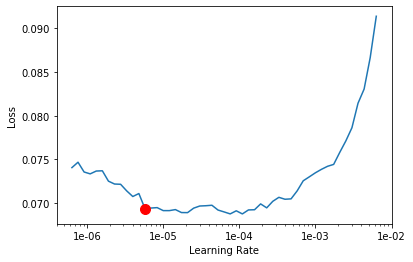

In [65]:
learner.recorder.plot(skip_end=7,suggestion=True)

In [ ]:
model_unfreezing_and_training()

# Predictions and Submission

Now that the model is trained, we can generate our predictions from the test dataset. As [noted in other tutorials](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) the function ``get_preds`` does not return elements in order by default. Therefore, we will have to resort the test elements into their correct order.

In [ ]:
#export
def get_preds_as_nparray(ds_type,unique_sorted_values,databunch)  -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    pos =0
    processed_pred=torch.empty(preds.shape[0],30)
    for j in range(len(unique_sorted_values)):
        column_distinct_size = len(unique_sorted_values[j])
        #processed_pred = self.labels[torch.argmax(torch.tensor(self.preds),1)]
        processed_pred[:,j] = torch.matmul(F.softmax(torch.tensor(preds[:,pos:(pos+column_distinct_size)]),1),
                                        torch.tensor(unique_sorted_values[j],dtype=torch.float))
        pos+=column_distinct_size
    processed_pred=processed_pred.numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return processed_pred[reverse_sampler, :]


In [ ]:
x = np.arange(10,1,-1)
labels=np.random.randn(9)
labels[a.astype(int)] 

In [ ]:
test_preds,test_preds.shape

In [ ]:
test_preds,test_preds.shape

In [ ]:
sample_submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
sample_submission[labels] = test_preds
sample_submission.to_csv("submission.csv", index=False)

We check the order

In [ ]:
test.head()

In [ ]:
sample_submission.head()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()